In [1]:
#%load_ext IPython.extensions.deduperreload
##%reload_ext autoreload
#%autoreload 2

In [2]:
%cd ../

/home/dmoreno/pipeline_v4_final/pipeline/training/stamp_classifier/models/experimentation/stamp_full


In [3]:
import pandas as pd
from get_data_from_db import get_database_engine
from get_data_from_db import get_detections
from alerce.core import Alerce
import requests
from notebooks.utils import *

## Consumir datos

In [4]:
df = pd.read_parquet('./data/stamp_classifier_2025_beta_firstmjd60814_SN.parquet', engine='pyarrow')
df_og = df.copy()
df.head()

,oid,ndet,meanra,meandec,deltajd,firstmjd,lastmjd,step_id_corr,class_name_stamp_old,classifier_name_stamp_old,classifier_version_stamp_old,probability_stamp_old,class_name_stamp_new,classifier_name_stamp_new,classifier_version_stamp_new,probability_stamp_new
0,ZTF25aaqqncg,25,25.153132,43.859619,9.996597,60814.493982,60824.490579,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.783749,SN,stamp_classifier_2025_beta,beta,0.969263
1,ZTF25aaqqmcb,9,18.780834,38.598613,9.996424,60814.489132,60824.485556,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.748484,SN,stamp_classifier_2025_beta,beta,0.615267
2,ZTF25aaqqlys,28,7.640684,22.299256,9.991875,60814.486285,60824.478160,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.759786,SN,stamp_classifier_2025_beta,beta,0.922652
3,ZTF19abjarlo,26,5.903281,16.055791,9.999711,60814.477986,60824.477697,27.5.6,SN,stamp_classifier,stamp_classifier_1.0.4,0.526442,SN,stamp_classifier_2025_beta,beta,0.991502
4,ZTF25aaqpzbl,9,332.699920,5.861327,10.040845,60814.420914,60824.461759,27.5.6,SN,stamp_classifier,stamp_classifier_1.0.4,0.792763,SN,stamp_classifier_2025_beta,beta,0.999278


In [5]:
oids = list(df_og.oid.unique())
len(oids)

1340

In [6]:
data_from_bbdd = pd.read_pickle('ale_data.pkl')
data_from_bbdd.shape

(1340, 23)

In [7]:
data_from_bbdd.isna().sum()

candid        0
ra            0
dec           0
magpsf        0
sigmapsf      0
isdiffpos     0
diffmaglim    0
classtar      0
fwhm          0
sgscore1      0
sgscore2      0
sgscore3      0
distpsnr1     0
distpsnr2     0
distpsnr3     0
ndethist      0
ncovhist      0
chinr         0
sharpnr       0
oid           0
science       0
reference     0
diff          0
dtype: int64

In [8]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

coords = SkyCoord(ra=data_from_bbdd['ra'],
                  dec=data_from_bbdd['dec'],
                  unit=(u.deg, u.deg))
data_from_bbdd['gal_l'] = coords.galactic.l.value
data_from_bbdd['gal_b'] = coords.galactic.b.value

# Barycentric mean ecliptic (used in ephem package)
data_from_bbdd['ecl_long'] = coords.barycentricmeanecliptic.lon.value
data_from_bbdd['ecl_lat'] = coords.barycentricmeanecliptic.lat.value

data_from_bbdd['non_detections'] = data_from_bbdd['ncovhist'] - data_from_bbdd['ndethist']
data_from_bbdd['oid'] = data_from_bbdd['oid'].str.strip("'")
#data_from_bbdd

gal_plane_l = np.linspace(0., 360., 360)
gal_plane_b = 0. * gal_plane_l
gal_plane_coords = SkyCoord(l=gal_plane_l,
                            b=gal_plane_b,
                            unit=(u.deg, u.deg),
                            frame='galactic')
gal_plane_ra = gal_plane_coords.icrs.ra.value
gal_plane_dec = gal_plane_coords.icrs.dec.value

ecl_plane_lon = np.linspace(0., 360., 360)
ecl_plane_lat = 0. * ecl_plane_lon

## Geocentric mean ecliptic
#ecl_plane_coords = SkyCoord(lon=ecl_plane_lon,
#                            lat=ecl_plane_lat,
#                            unit=(u.deg, u.deg),
#                            frame='geocentricmeanecliptic')
# Barycentric mean ecliptic (used in ephem package)
ecl_plane_coords = SkyCoord(lon=ecl_plane_lon,
                            lat=ecl_plane_lat,
                            unit=(u.deg, u.deg),
                            frame='barycentricmeanecliptic')

ecl_plane_ra = ecl_plane_coords.icrs.ra.value
ecl_plane_dec = ecl_plane_coords.icrs.dec.value

data_from_bbdd['isdiffpos'] = data_from_bbdd['isdiffpos'].replace({'f': -1, 't': 1})
data_from_bbdd

/tmp/ipykernel_2988267/2271859403.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_from_bbdd['isdiffpos'] = data_from_bbdd['isdiffpos'].replace({'f': -1, 't': 1})


,candid,ra,dec,magpsf,sigmapsf,isdiffpos,diffmaglim,classtar,fwhm,sgscore1,...,sharpnr,oid,science,reference,diff,gal_l,gal_b,ecl_long,ecl_lat,non_detections
0,3060493982415015031,25.153091,43.859624,17.384464,0.096363,1,17.856308,1.0,4.48,0.5,...,0.488,ZTF25aaqqncg,"[[357.63672, 370.00098, 363.46094, 383.46973, ...","[[360.51163, 361.28806, 360.6447, 360.36313, 3...","[[-2.5353675, 4.524429, 3.9984815, 18.700296, ...",132.228123,-18.122714,40.467855,30.918026,4231
1,3060489134115015002,18.780895,38.598633,18.843658,0.191693,1,18.695026,0.959,1.463208,1.0,...,-0.033,ZTF25aaqqmcb,"[[259.1941, 298.25122, 265.2058, 305.87305, 24...","[[264.56293, 263.4999, 263.81665, 265.84186, 2...","[[-8.044159, 34.135082, -1.8801003, 41.03674, ...",127.996837,-24.040067,32.918115,28.183335,312
2,3060486282515015002,7.640819,22.299308,19.169945,0.191345,1,18.997227,0.955,4.2,0.030833,...,0.063,ZTF25aaqqlys,"[[148.12598, 156.34412, 172.22339, 119.619995,...","[[152.29463, 149.08484, 148.8748, 150.26053, 1...","[[-4.033482, 10.309769, 22.37847, -20.022255, ...",116.595417,-40.315469,16.049452,17.409550,2011
3,3060484674715015004,5.903405,16.055986,19.08963,0.190222,1,19.092031,0.969,3.68,0.00225,...,0.048,ZTF19abjarlo,"[[152.46716, 136.40454, 124.61072, 174.70105, ...","[[153.73677, 150.51335, 146.39339, 147.51881, ...","[[-0.41995475, -14.362872, -21.295073, 25.8558...",113.235360,-46.291241,11.857559,12.382545,1918
4,3060420913315015010,332.699892,5.861284,18.640308,0.087633,1,19.365599,0.982,2.95,0.5,...,0.968,ZTF25aaqpzbl,"[[120.77875, 108.11975, 153.34576, 106.94879, ...","[[130.38007, 129.69154, 129.4728, 130.11423, 1...","[[-8.81582, -21.536238, 24.532125, -19.291397,...",67.226828,-39.054049,336.848596,15.972780,1542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,3060278744315015003,157.446580,55.765790,19.177732,0.168594,1,19.800554,0.621,5.92,0.004167,...,-0.376,ZTF25aaqomrj,"[[171.73294, 173.55493, 166.68356, 182.85382, ...","[[168.34567, 171.22499, 171.49261, 169.75699, ...","[[4.5400414, 0.744071, -0.15739587, 8.351831, ...",154.685563,51.724449,134.601608,42.275327,2797
1336,3060278744215015011,156.835737,55.414955,19.692469,0.21168,1,19.803247,0.918,6.2,0.000833,...,-0.272,ZTF25aaqompw,"[[162.22876, 165.48245, 170.4454, 154.55579, 1...","[[160.35767, 162.28308, 162.86081, 161.42805, ...","[[3.2479854, 0.93505085, 9.534031, -7.508344, ...",155.463448,51.626709,134.430508,41.799837,2942
1337,3060278744715015021,153.893988,55.137045,19.210068,0.167329,1,19.840748,0.635,5.2,0.5,...,0.157,ZTF25aaqomnq,"[[157.46027, 142.42722, 164.01337, 153.76416, ...","[[153.23105, 154.45256, 156.063, 156.33965, 15...","[[0.18195322, -10.044236, 3.8135884, 0.1867181...",157.199378,50.326557,132.653793,40.750107,5365
1338,3060278274715015004,153.424520,48.345893,19.787155,0.206858,1,19.850525,0.816,2.74,0.984375,...,-0.473,ZTF25aaqommt,"[[81.75925, 94.64755, 87.68033, 97.182526, 99....","[[96.44252, 97.052864, 95.86814, 94.708336, 95...","[[-14.440532, -2.0463927, -11.413828, -2.24406...",167.345666,52.896952,136.200372,34.558028,2881


In [9]:
data_from_bbdd.dtypes

candid             object
ra                float64
dec               float64
magpsf             object
sigmapsf           object
isdiffpos           int64
diffmaglim         object
classtar           object
fwhm               object
sgscore1           object
sgscore2           object
sgscore3           object
distpsnr1          object
distpsnr2          object
distpsnr3          object
ndethist           object
ncovhist           object
chinr              object
sharpnr            object
oid                object
science            object
reference          object
diff               object
gal_l             float64
gal_b             float64
ecl_long          float64
ecl_lat           float64
non_detections     object
dtype: object

In [10]:
#aqui necesito definir la funcion para entregar las preds
def find_probs_r1(oids,pred_df):
    #recibo la lista de oids y hago las predicciones.
    #las predicciones ya estan en pred_prob, tomo el elemento maximo y el nombre de la clase

    df = pred_df.loc[oids].copy()

    # Encontrar la clase con mayor probabilidad y su valor
    clase = df.idxmax(axis=1)
    prob = df.max(axis=1)

    df['class_name_stamp_new'] = clase
    df['classifier_name_stamp_new'] = 'stamp'
    df['classifier_version_stamp_new'] = 'stamp_classifier_1.0.4'
    df['probability_stamp_new'] = prob
    
    return df[['class_name_stamp_new','classifier_name_stamp_new','classifier_version_stamp_new','probability_stamp_new']]

In [11]:
import tensorflow as tf
import glob
import yaml

from alerce_classifiers.stamp_full.mapper import StampFullMapper
from model import StampModelModified, StampModelFull

PATH_MODELS_LIST = sorted(glob.glob('results_incremental/*'))
print('Number of experiments: ', len(PATH_MODELS_LIST))


global_results = {}
for PATH_MODELS in PATH_MODELS_LIST:
    print(f"\n==========================")
    print(f"Processing experiment: {PATH_MODELS}")
    print(f"==========================")


    # CONFIG
    config_path = os.path.join(PATH_MODELS, 'run_0', 'config_used.yaml')
    if not os.path.exists(config_path):
        print(f"Warning: {config_path} not found, skipping {PATH_MODELS}/run_0")
        continue

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    hp_model = config['hp_model']
    args_general = config['args_general']


    keras_model_files = [f for f in os.listdir(f'{PATH_MODELS}/run_0') if f.startswith('model_') and f.endswith('.keras')]
    if len(keras_model_files) == 0:
        print(f"Warning: No .keras model found in {f'{PATH_MODELS}/run_0'}, skipping run_0")
        continue
    keras_model_file = keras_model_files[0] 
    keras_model_path = os.path.join(f'{PATH_MODELS}/run_0', keras_model_file)
    if hp_model['model'] == 'full':
        model = tf.keras.models.load_model(keras_model_path, custom_objects={"StampModelFull": StampModelFull})
    else:
        model = tf.keras.models.load_model(keras_model_path, custom_objects={"StampModelModified": StampModelModified})

    dict_classes_training_to_prod = {
        "agn": "AGN",
        "asteroid": "asteroid",
        "bogus": "bogus",
        "satellite": "satellite",
        "sn": "SN",
        "vs": "VS",
    }

    class_names = [
        dict_classes_training_to_prod[model.dict_mapping_classes[i]]
        for i in sorted(model.dict_mapping_classes.keys())
    ]

    # DATA
    stamps = data_from_bbdd.set_index('oid')

    # DATA PREPROCESSING
    input_data, md_data, aid_index, asteroids = StampFullMapper().preprocess(stamps, class_names)

    if args_general['use_metadata']:
        md_data = stamps[model.order_features]
        md_data = md_data.fillna(-999)
        clipping_rules = {
            'sgscore1': (-1, None),
            'distpsnr1': (-1, None),
            'sgscore2': (-1, None),
            'distpsnr2': (-1, None),
            'sgscore3': (-1, None),
            'distpsnr3': (-1, None),
            'fwhm': (None, 10),
            'ndethist': (None, 20),
            'ncovhist': (None, 3000),
            'chinr': (-1, 15),
            'sharpnr': (-1, 1.5),
            'non_detections': (None, 2000)
        }
        for feature, (min_val, max_val) in clipping_rules.items():
            if feature in md_data.columns:
                if min_val is not None:
                    md_data[feature] = md_data[feature].clip(lower=min_val)
                if max_val is not None:
                    md_data[feature] = md_data[feature].clip(upper=max_val)

        md_data = (md_data - model.norm_means) / model.norm_stds
        md_data = md_data.values

    probs = []
    if input_data is not None:
        with tf.device("/cpu:0"):
            probs = tf.nn.softmax(model((input_data, md_data)))

    pred_prob = StampFullMapper().postprocess(
        probs, 
        asteroids=asteroids,
        stamps=stamps,
        taxonomy=class_names,
        index=aid_index,
        ).probabilities
    
    df_aux = df_og.set_index('oid').drop(['class_name_stamp_new','classifier_name_stamp_new',
                                        'classifier_version_stamp_new','probability_stamp_new'], axis=1)
    # Obtener predicciones
    preds = find_probs_r1(oids=[oid.strip("'") for oid in oids], pred_df=pred_prob)
    # Hacer join por índice (oid)
    df_final_og = df_aux.join(preds, how='left')
    global_results[PATH_MODELS] = df_final_og

2025-06-06 08:46:46.735227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of experiments:  12

Processing experiment: results_incremental/2025-06-06_06-45-00


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_06-53-00


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-10-02


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-19-40


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-26-58


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-38-05


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-48-49


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_07-54-57


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_08-03-17


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_08-10-13


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_08-22-13


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)



Processing experiment: results_incremental/2025-06-06_08-33-39


/tmp/ipykernel_2988267/539618767.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  md_data = md_data.fillna(-999)


In [12]:
df_final_og

,ndet,meanra,meandec,deltajd,firstmjd,lastmjd,step_id_corr,class_name_stamp_old,classifier_name_stamp_old,classifier_version_stamp_old,probability_stamp_old,class_name_stamp_new,classifier_name_stamp_new,classifier_version_stamp_new,probability_stamp_new
oid,,,,,,,,,,,,,,,
ZTF25aaqqncg,25,25.153132,43.859619,9.996597,60814.493982,60824.490579,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.783749,satellite,stamp,stamp_classifier_1.0.4,0.952057
ZTF25aaqqmcb,9,18.780834,38.598613,9.996424,60814.489132,60824.485556,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.748484,bogus,stamp,stamp_classifier_1.0.4,0.581644
ZTF25aaqqlys,28,7.640684,22.299256,9.991875,60814.486285,60824.478160,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.759786,satellite,stamp,stamp_classifier_1.0.4,0.641415
ZTF19abjarlo,26,5.903281,16.055791,9.999711,60814.477986,60824.477697,27.5.6,SN,stamp_classifier,stamp_classifier_1.0.4,0.526442,SN,stamp,stamp_classifier_1.0.4,0.769568
ZTF25aaqpzbl,9,332.699920,5.861327,10.040845,60814.420914,60824.461759,27.5.6,SN,stamp_classifier,stamp_classifier_1.0.4,0.792763,SN,stamp,stamp_classifier_1.0.4,0.646995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF25aaqomrj,1,157.446580,55.765790,0.000000,60814.278750,60814.278750,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.733461,satellite,stamp,stamp_classifier_1.0.4,0.672666
ZTF25aaqompw,1,156.835737,55.414955,0.000000,60814.278750,60814.278750,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.756680,satellite,stamp,stamp_classifier_1.0.4,0.607091
ZTF25aaqomnq,1,153.893988,55.137045,0.000000,60814.278750,60814.278750,27.5.6,bogus,stamp_classifier,stamp_classifier_1.0.4,0.695921,satellite,stamp,stamp_classifier_1.0.4,0.706650


In [13]:
def plot_2distribs_radecprob(df=None, cls=None, firstmjd_min='',
                             fontsize=12, namefig=None, showfig=True,
                             gal_plane_ra=None, gal_plane_dec=None,
                             ecl_plane_ra=None, ecl_plane_dec=None,
                             which_version='both',
                             suptitle_custom=None):  # NEW ARGUMENT
    
    plt.rcParams.update({'font.size': fontsize})
    cmap = 'coolwarm'
    alpha = 0.5

    for (propx, propy, coordtype) in zip(['meanra'], ['meandec'], ['equatorial']):
        
        # Si graficamos 'old' o 'new' → nrows = 1
        if which_version in ['old', 'new']:
            fig, ax = plt.subplots(ncols=len(cls), nrows=1, figsize=(len(cls) * 5, 4))
            if len(cls) == 1:
                ax = [ax]
        else:
            # Caso 'both' → original de 2 filas
            fig, ax = plt.subplots(ncols=len(cls), nrows=2, figsize=(len(cls) * 5, 8))
            if len(cls) == 1:
                ax = [ax, ax]

        # Construir el título
        if suptitle_custom is not None:
            suptitle = suptitle_custom
        else:
            if which_version == 'old':
                suptitle = classifier_names2[0] + ' (OLD), firstmjd=' + str(int(firstmjd_min))
            elif which_version == 'new':
                suptitle = classifier_names2[1] + ' (NEW), firstmjd=' + str(int(firstmjd_min))
            else:
                suptitle = classifier_names2[0] + ' (top), '+ classifier_names2[1] \
                           + ' (bottom), firstmjd=' + str(int(firstmjd_min))
        
        fig.suptitle(suptitle, fontsize=fontsize + 2)

        # Loop over classifier_names2 (old and new)
        for i, clf_name in enumerate(classifier_names2):
            
            # Nuevo control: skip si no corresponde
            if which_version == 'old' and i != 0:
                continue
            if which_version == 'new' and i != 1:
                continue
            
            propcolor = 'probability_' + clf_name

            for j, cl_this in enumerate(cls):
                if cl_this == 'all':
                    df_aux = df[df['class_name_' + clf_name].notna()].copy()
                else:
                    mask = df['class_name_' + clf_name] == cl_this
                    df_aux = df[mask].copy()

                if len(df_aux) > 0:
                    title_aux = cl_this + ' (' + str(len(df_aux)) + ' objs)'

                    # Determinar si es 1 fila o 2 filas
                    if which_version in ['old', 'new']:
                        ax_target = ax[j]
                    else:
                        ax_target = ax[ax_row][j]

                    sc = ax_target.scatter(df_aux[propx], df_aux[propy], c=df_aux[propcolor],
                                        cmap=cmap, s=10, alpha=alpha)
                    plt.colorbar(sc, ax=ax_target, label=propcolor)

                    if coordtype == 'equatorial':
                        ax_target.scatter(gal_plane_ra, gal_plane_dec, s=5, c='magenta', alpha=0.5)
                        ax_target.scatter(ecl_plane_ra, ecl_plane_dec, s=5, c='cyan', alpha=0.5)

                    ax_target.set_xlabel(propx)
                    ax_target.set_ylabel(propy)
                    ax_target.set_title(title_aux, fontsize=fontsize + 1)
                    ax_target.set_xlim([0, 360])
                    ax_target.set_ylim([-90, 90])


    plt.tight_layout()

    if namefig is not None:
        fig.savefig(namefig, bbox_inches='tight')

    if fontsize is not None:
        plt.rcParams.update({'font.size': 12})

    if not showfig:
        plt.close(fig)
    return



Plotting model (StampNew): results_incremental/2025-06-06_06-45-00

Plotting model (StampNew): results_incremental/2025-06-06_06-53-00

Plotting model (StampNew): results_incremental/2025-06-06_07-10-02

Plotting model (StampNew): results_incremental/2025-06-06_07-19-40

Plotting model (StampNew): results_incremental/2025-06-06_07-26-58

Plotting model (StampNew): results_incremental/2025-06-06_07-38-05

Plotting model (StampNew): results_incremental/2025-06-06_07-48-49

Plotting model (StampNew): results_incremental/2025-06-06_07-54-57

Plotting model (StampNew): results_incremental/2025-06-06_08-03-17

Plotting model (StampNew): results_incremental/2025-06-06_08-10-13

Plotting model (StampNew): results_incremental/2025-06-06_08-22-13

Plotting model (StampNew): results_incremental/2025-06-06_08-33-39


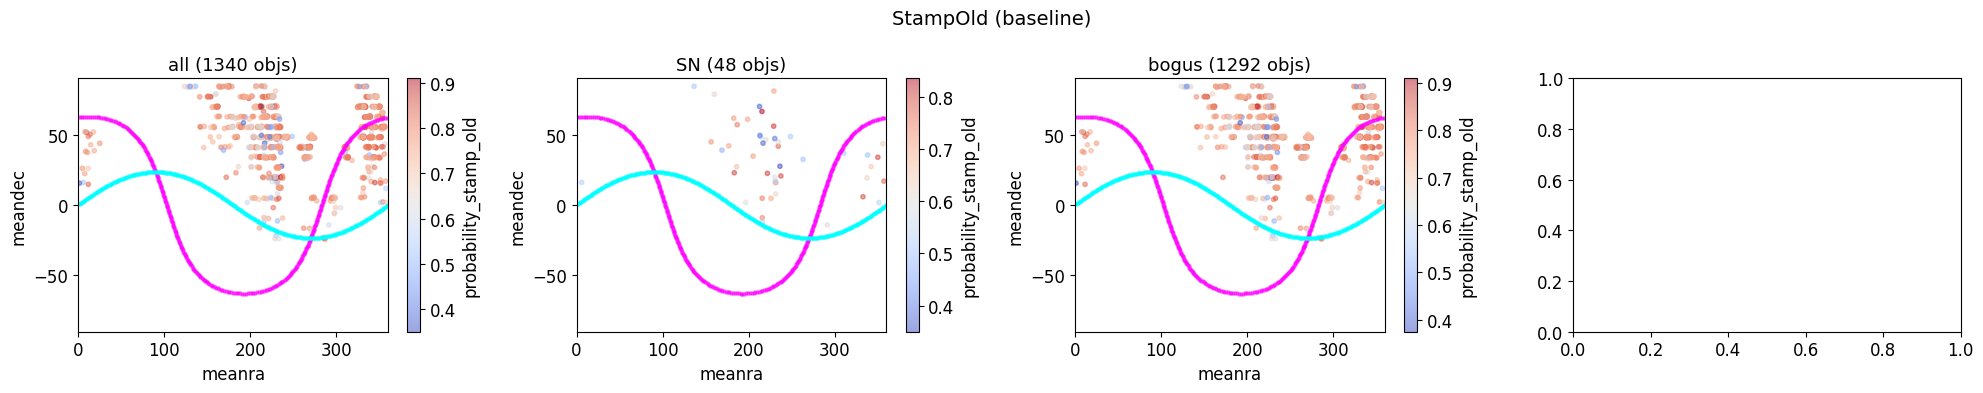

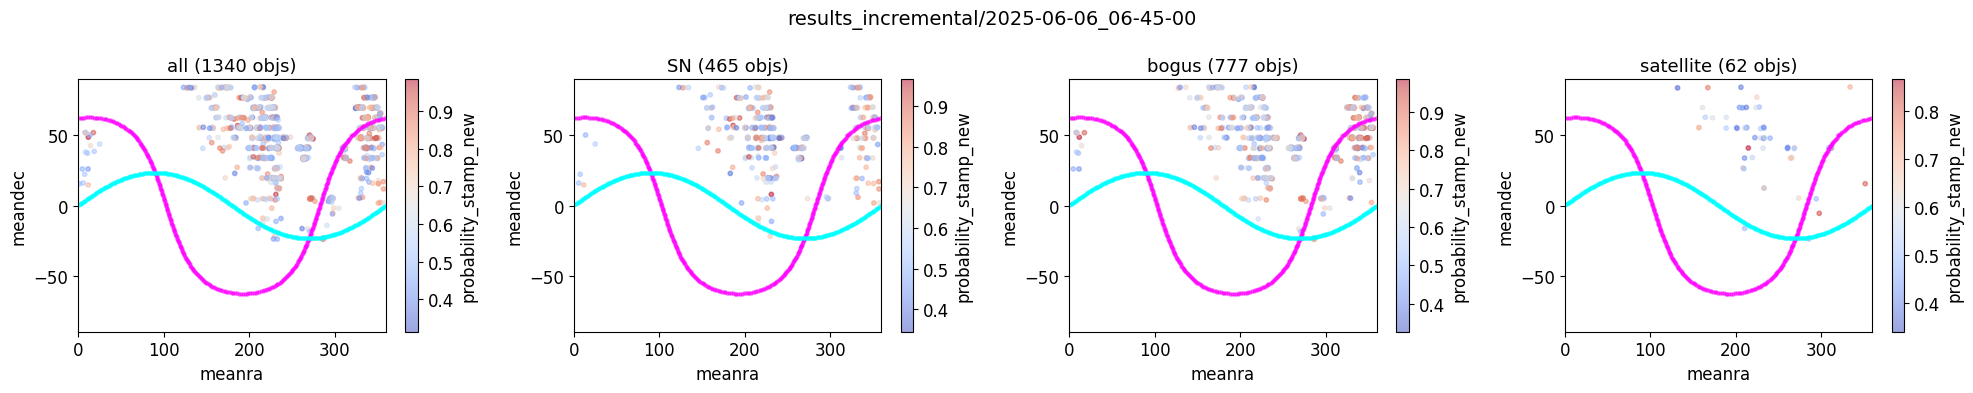

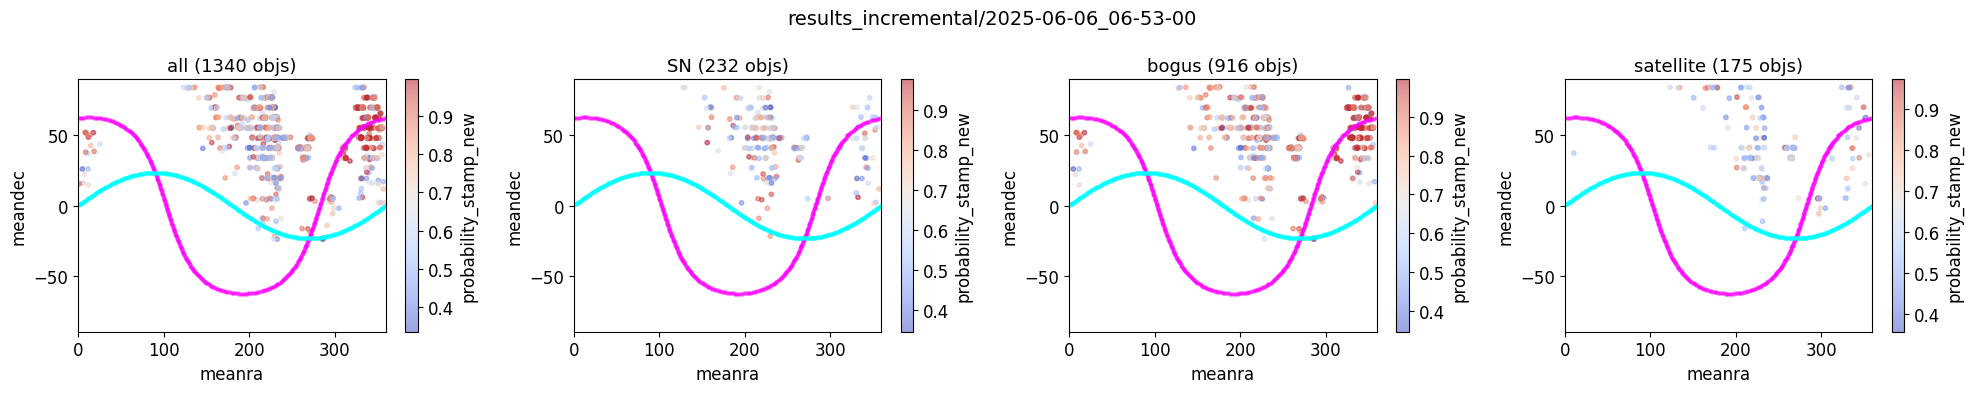

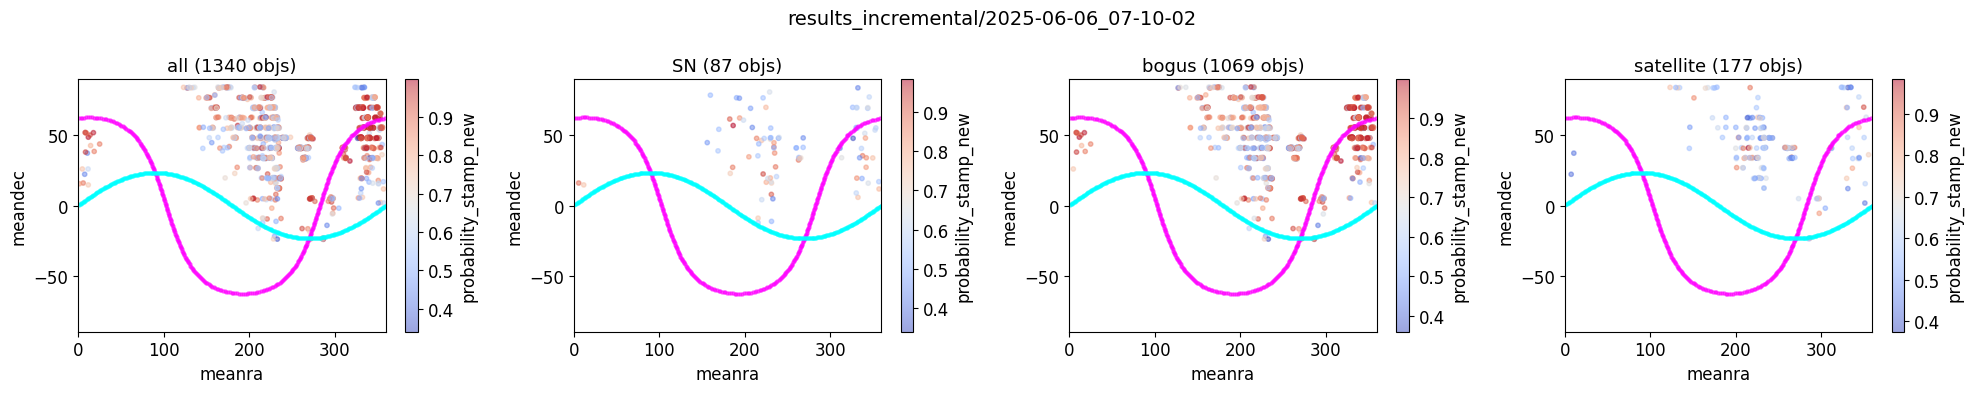

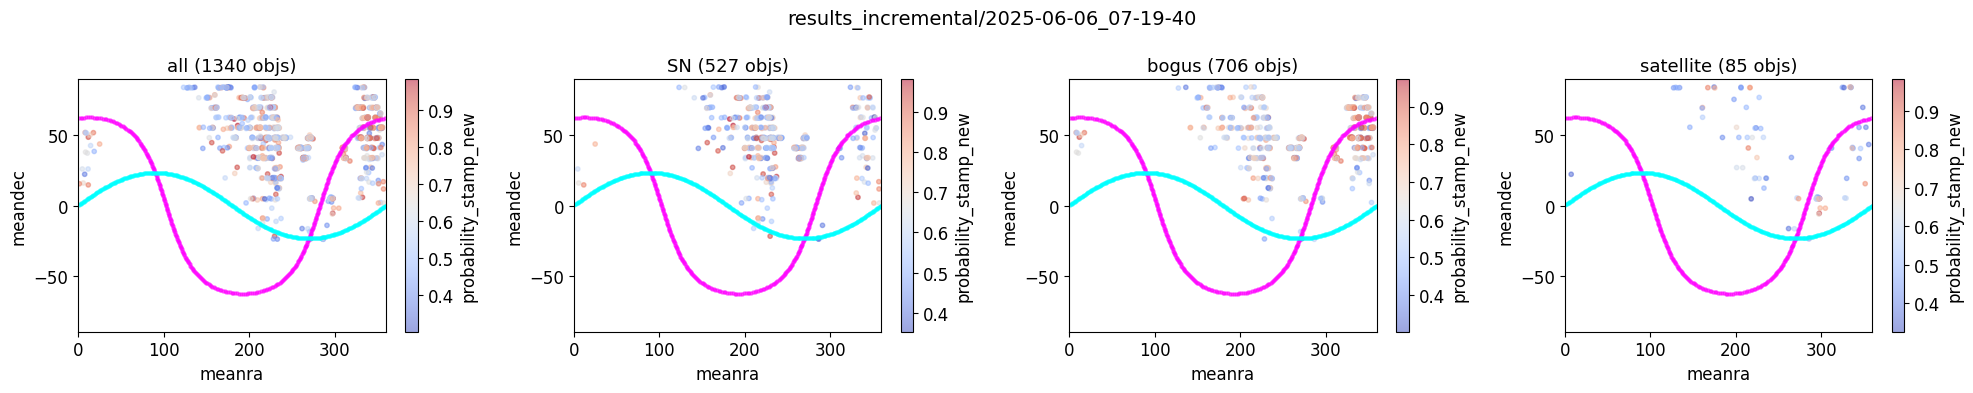

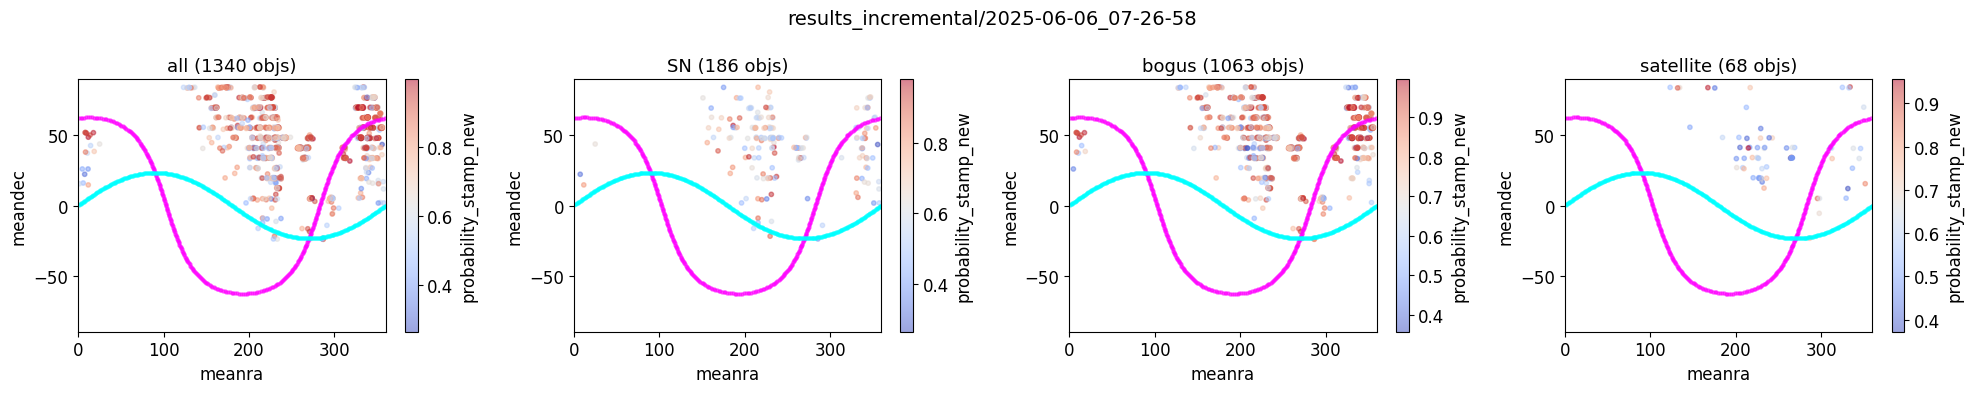

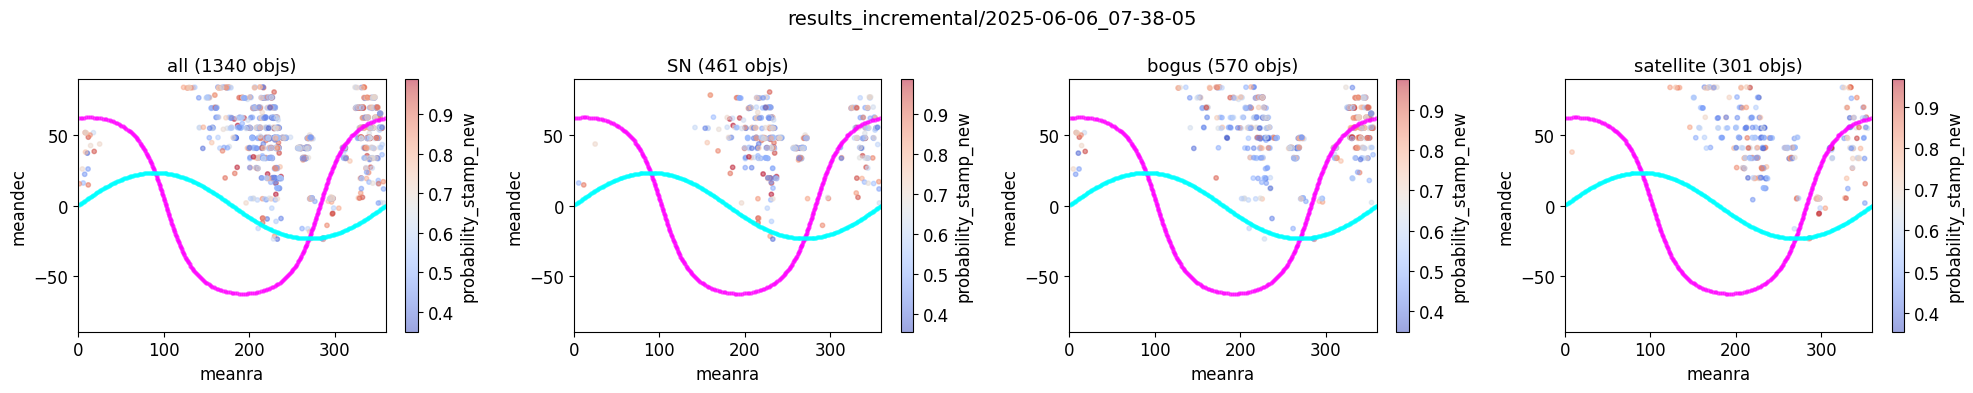

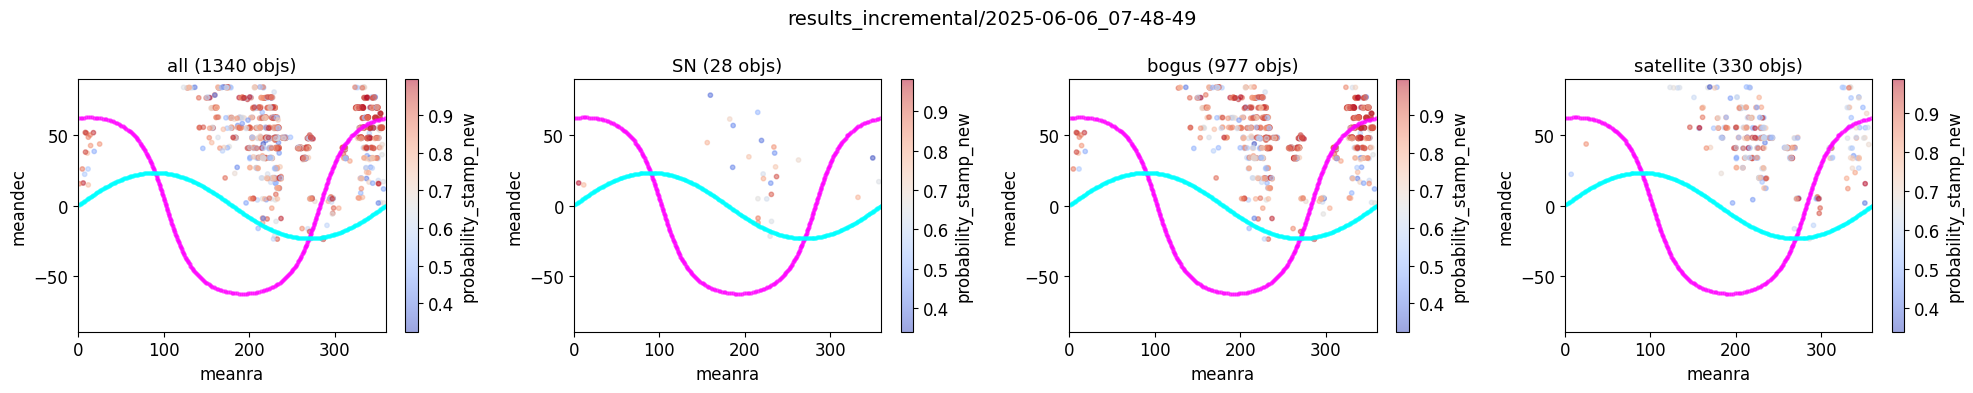

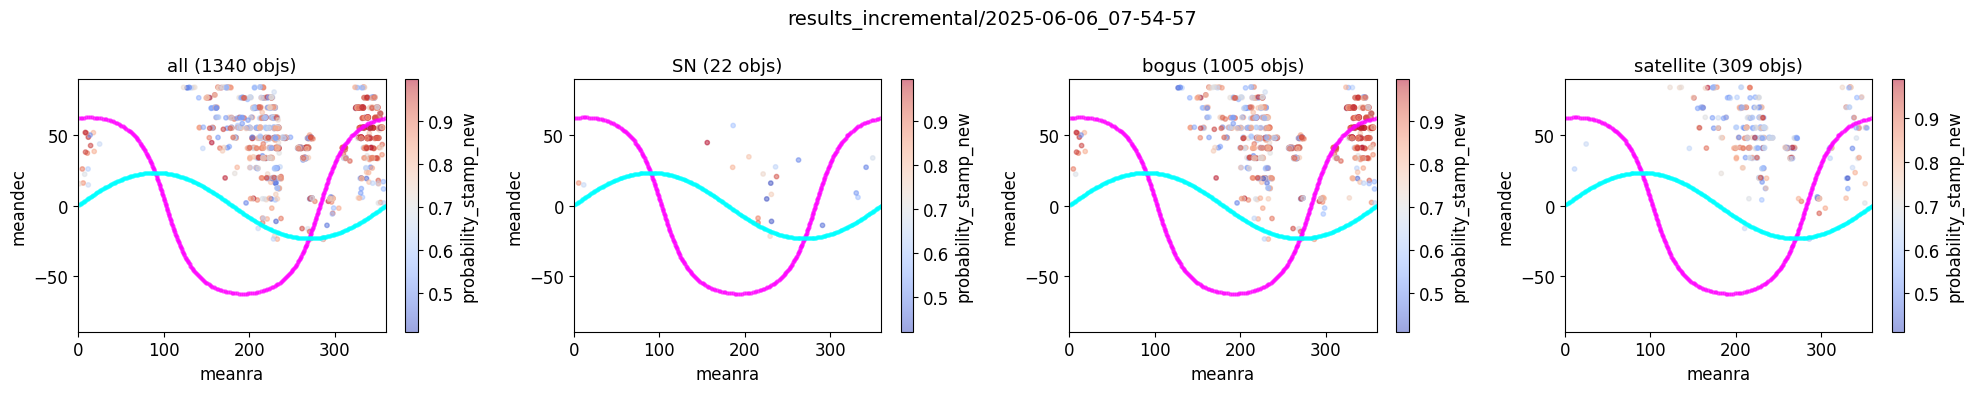

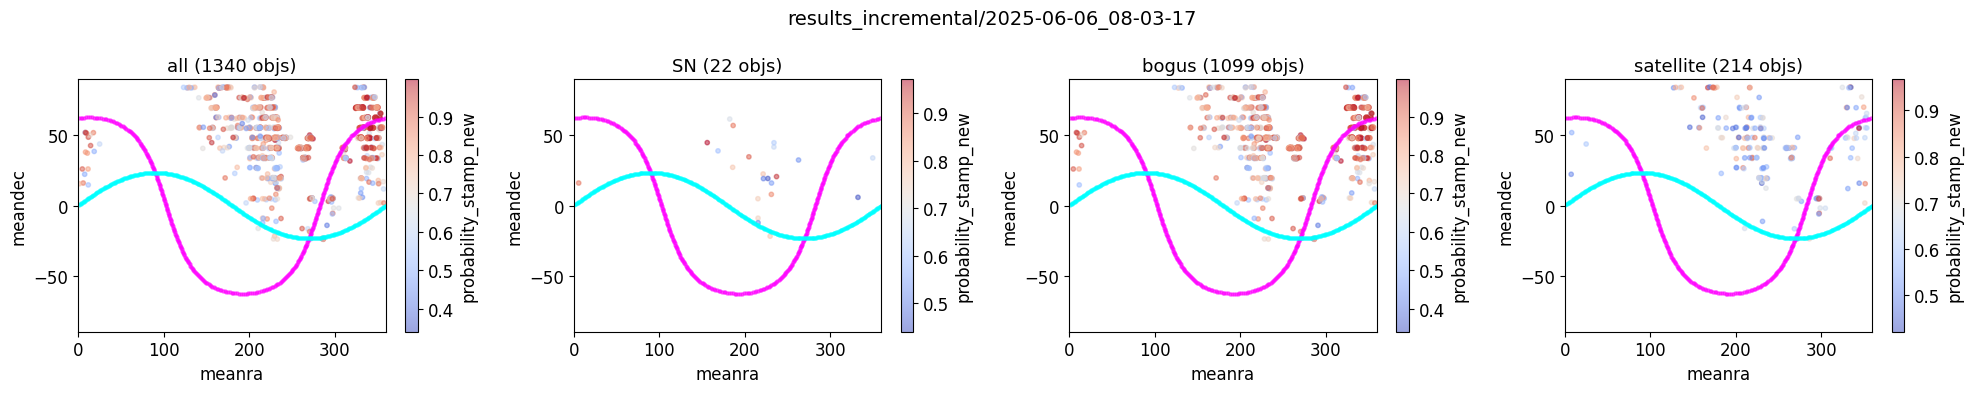

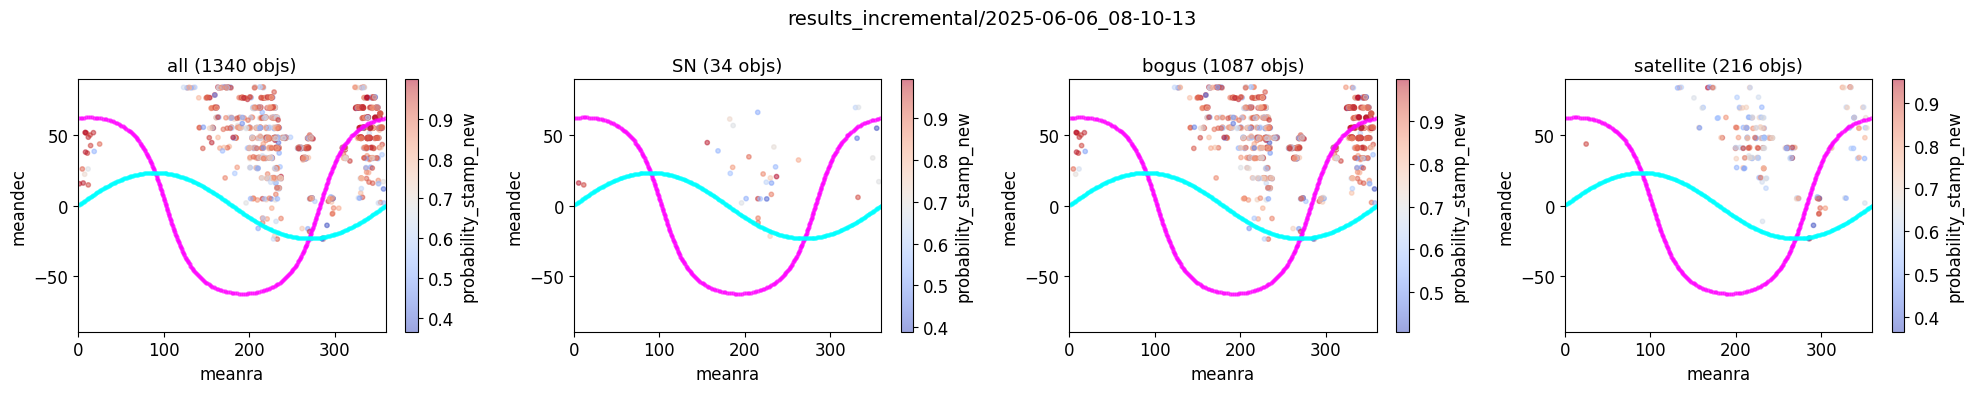

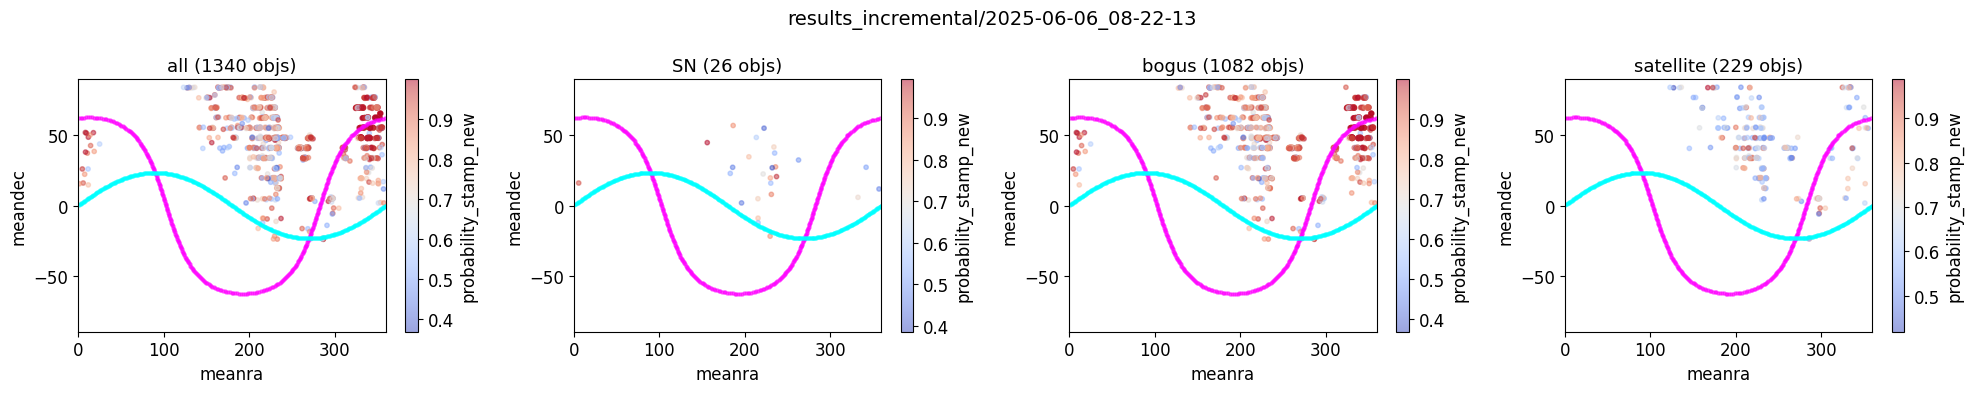

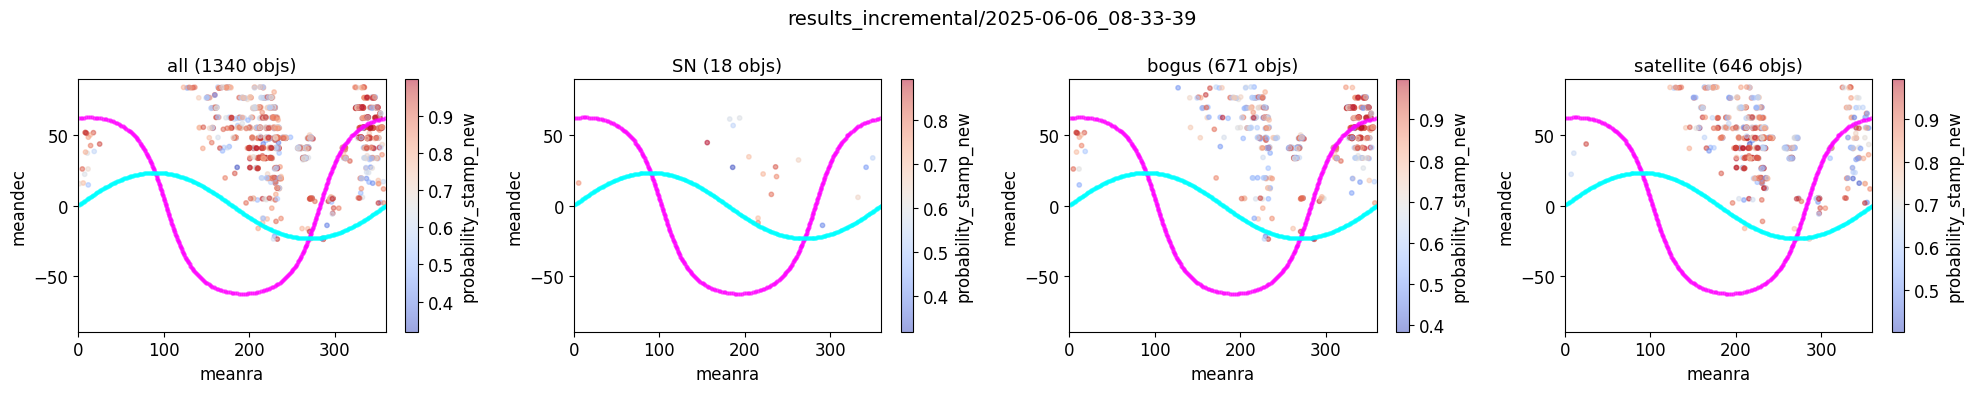

In [14]:
cls_aux = ['all', 'SN', 'bogus', 'satellite']
fontsize = 12

plot_2distribs_radecprob(df=df_final_og, cls=cls_aux,
                         firstmjd_min='0', fontsize=fontsize,
                         gal_plane_ra=gal_plane_ra, gal_plane_dec=gal_plane_dec,
                         ecl_plane_ra=ecl_plane_ra, ecl_plane_dec=ecl_plane_dec,
                         which_version='old',
                         suptitle_custom='StampOld (baseline)')

for model_path, df_model in global_results.items():
    print(f"\nPlotting model (StampNew): {model_path}")
    
    model_name = os.path.basename(model_path)
    
    plot_2distribs_radecprob(df=df_model, cls=cls_aux,
                             firstmjd_min='0', fontsize=fontsize,
                             gal_plane_ra=gal_plane_ra, gal_plane_dec=gal_plane_dec,
                             ecl_plane_ra=ecl_plane_ra, ecl_plane_dec=ecl_plane_dec,
                             which_version='new',
                             suptitle_custom=model_path)

In [43]:
global_results.keys()

dict_keys(['results_incremental/2025-06-06_06-45-00', 'results_incremental/2025-06-06_06-53-00', 'results_incremental/2025-06-06_07-10-02', 'results_incremental/2025-06-06_07-19-40', 'results_incremental/2025-06-06_07-26-58', 'results_incremental/2025-06-06_07-38-05', 'results_incremental/2025-06-06_07-48-49', 'results_incremental/2025-06-06_07-54-57', 'results_incremental/2025-06-06_08-03-17', 'results_incremental/2025-06-06_08-10-13'])

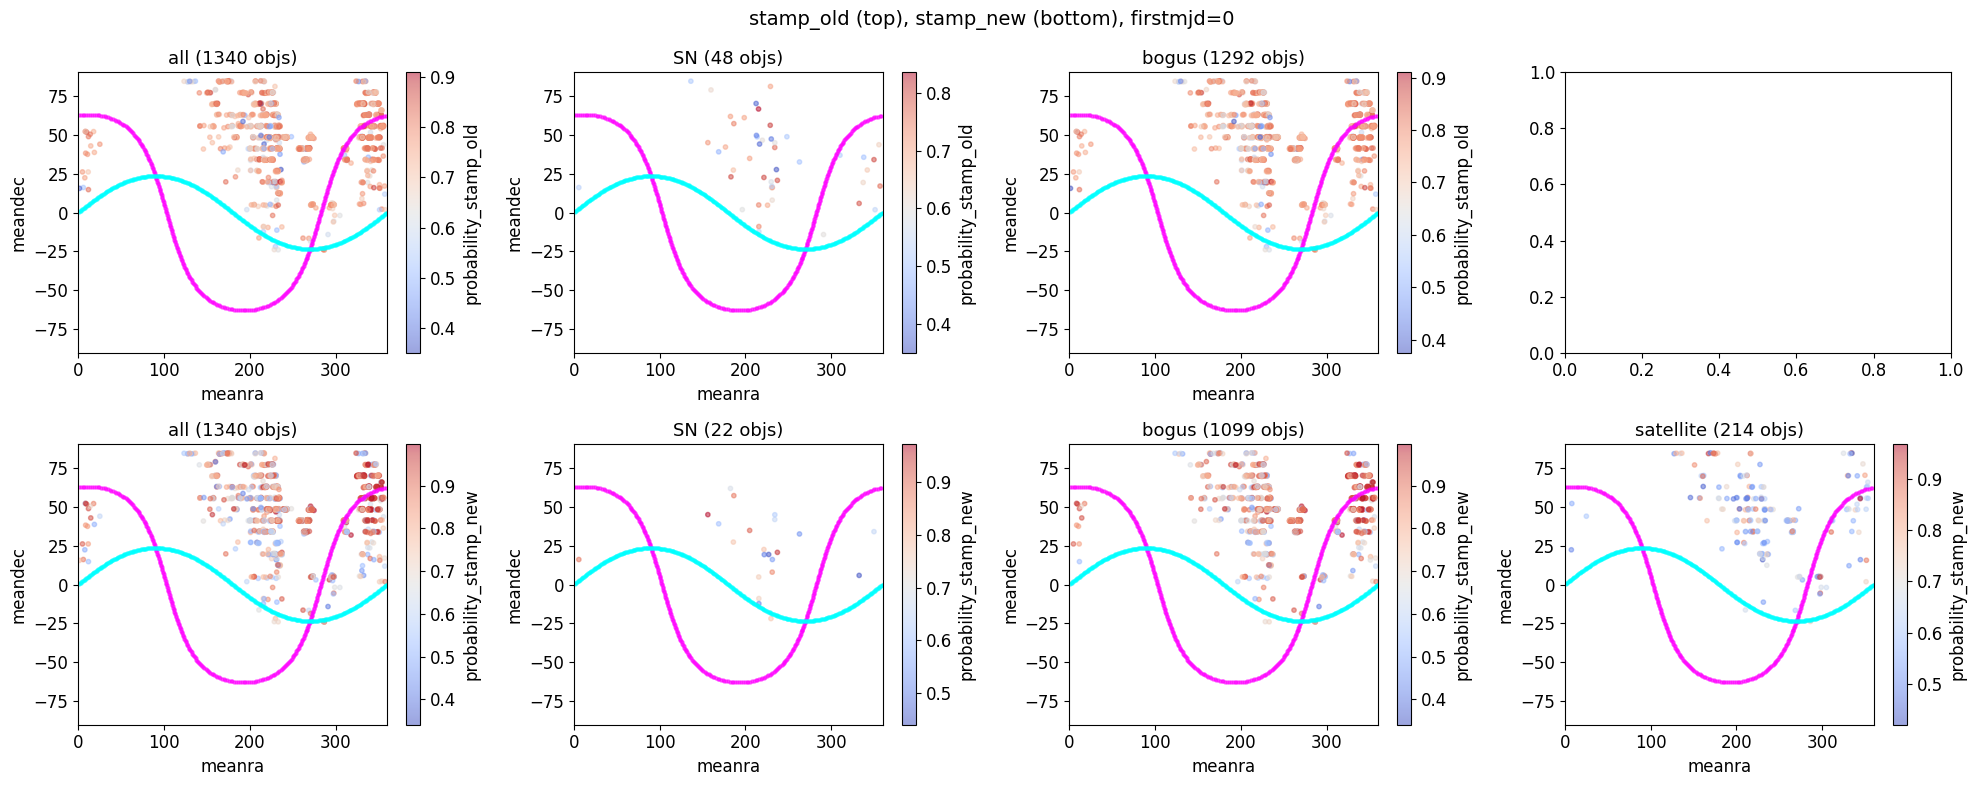

In [46]:
from notebooks.utils import plot_2distribs_radecprob

cls_aux = ['all', 'SN', 'bogus', 'satellite']
plot_2distribs_radecprob(df=global_results['results_incremental/2025-06-06_08-03-17'], cls=cls_aux,
                         firstmjd_min='0', fontsize=fontsize,gal_plane_ra=gal_plane_ra
                         ,gal_plane_dec=gal_plane_dec,ecl_plane_ra=ecl_plane_ra, ecl_plane_dec=ecl_plane_dec)